In [1]:
import numpy as np
import pandas as pd
from river import optim
from river import metrics
from river.drift.binary import EDDM
from sail.telemetry import TracingClient
from sail.models.auto_ml.tune import SAILTuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.keras import KerasSequentialClassifier
from sail.models.auto_ml.auto_pipeline import SAILAutoPipeline
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
from sail.drift_detection.drift_detector import SAILDriftDetector
from sail.transformers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
X = pd.read_csv("../../datasets/agrawal.csv").head(50000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)
keras = KerasSequentialClassifier(
    num_hidden_nodes= [10],
    hidden_layer_activation= ["relu"],
    num_output_nodes= 1,
    outer_layer_activation="sigmoid"
)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(steps=steps, scoring=metrics.Accuracy, verbosity_level=1, verbosity_interval=1)

#### HPO Params


In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
    {
        "classifier": [keras],
        "classifier__num_hidden_nodes": [[5], [10]]
    }
]


#### Create Model Instance


In [6]:
# tracer = TracingClient(service_name="SAIL_Testing", otlp_endpoint="http://localhost:4318")

auto_pipeline = SAILAutoPipeline(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    search_method=SAILTuneGridSearchCV,
    search_method_params={
        "num_cpus_per_trial": 1,
        "max_iters": 1,
        "early_stopping": False,
        "mode": "max",
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
        "keep_best_configurations": 2
    },
    search_data_size=1000,
    incremental_training=True,
    drift_detector=SAILDriftDetector(model=EDDM(), drift_param="difference"),
    pipeline_strategy="DetectAndIncrement",
    verbosity_level=1, 
    verbosity_interval=1,
    tensorboard_log_dir=None,
    tracer=None
)

[2023-10-08 22:40:32:937] - INFO - SAIL (PipelineStrategy) - Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Start Training


In [7]:
y_preds = []
y_true = []
batch_size = 50

#with tracer.trace_as_current_span(span_name="Pipeline-Train"):
for start in range(0, 2000, batch_size):

    end = start + batch_size

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if start == 0:
        keras.fit(X_train, y_train)

    if end > 1000: # search_data_size is 1000
        preds = auto_pipeline.predict(X_train)
        if preds is not None:
            y_preds.extend(list(preds))
            y_true.extend(list(y_train))

    auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])


INFO:tensorflow:Assets written to: ram://e04ea498580e46688ed640e96f20be45/assets


INFO:tensorflow:Assets written to: ram://e04ea498580e46688ed640e96f20be45/assets


INFO:tensorflow:Assets written to: ram://f9ac0acfed7a48d19ae161328f112514/assets


INFO:tensorflow:Assets written to: ram://f9ac0acfed7a48d19ae161328f112514/assets
2023-10-08 22:40:42.577625: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1e171bb4fbe14b7db17461afa934e0d6: INVALID_ARGUMENT: ram://1e171bb4fbe14b7db17461afa934e0d6 is a directory.


INFO:tensorflow:Assets written to: ram://9cbe6f15b78e47b4afd29dc67309f4cc/assets


INFO:tensorflow:Assets written to: ram://9cbe6f15b78e47b4afd29dc67309f4cc/assets
2023-10-08 22:40:43.079824: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://933b4bb267b3475287a970b6b8a2367e: INVALID_ARGUMENT: ram://933b4bb267b3475287a970b6b8a2367e is a directory.


INFO:tensorflow:Assets written to: ram://bceb8fad446c4e03b5242c5308f79ded/assets


INFO:tensorflow:Assets written to: ram://bceb8fad446c4e03b5242c5308f79ded/assets
2023-10-08 22:40:43.762393: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://860438c2ed234bcfb7e6ad98fb69e87c: INVALID_ARGUMENT: ram://860438c2ed234bcfb7e6ad98fb69e87c is a directory.


INFO:tensorflow:Assets written to: ram://32c2f1dabebe43a59a0fac91f654c9f8/assets


INFO:tensorflow:Assets written to: ram://32c2f1dabebe43a59a0fac91f654c9f8/assets


INFO:tensorflow:Assets written to: ram://d10cc802a132487dbf84dada637942fd/assets


INFO:tensorflow:Assets written to: ram://d10cc802a132487dbf84dada637942fd/assets
2023-10-08 22:40:45.664026: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://18419d5dde714f0c805a22814b9cf97a: INVALID_ARGUMENT: ram://18419d5dde714f0c805a22814b9cf97a is a directory.


INFO:tensorflow:Assets written to: ram://a2ac76d6c4a74702b964b1c5da60b0c5/assets


INFO:tensorflow:Assets written to: ram://a2ac76d6c4a74702b964b1c5da60b0c5/assets


INFO:tensorflow:Assets written to: ram://7af6b67ffa2049d2a0a1b79dc1967dd3/assets


INFO:tensorflow:Assets written to: ram://7af6b67ffa2049d2a0a1b79dc1967dd3/assets
(_Trainable pid=47138) 2023-10-08 22:40:48.052937: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://45b64747ffd94728bb95a62446829dd7: INVALID_ARGUMENT: ram://45b64747ffd94728bb95a62446829dd7 is a directory.


INFO:tensorflow:Assets written to: ram://66143c7abcfc4f5fb7d9c534bd8e1eb2/assets


INFO:tensorflow:Assets written to: ram://66143c7abcfc4f5fb7d9c534bd8e1eb2/assets
(_Trainable pid=47138) WARNING:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://7763cd0905cb4170a2e1cf956435d465/assets


INFO:tensorflow:Assets written to: ram://7763cd0905cb4170a2e1cf956435d465/assets


INFO:tensorflow:Assets written to: ram://abfe9ba0b9444af481bf7f3cc808f47b/assets


INFO:tensorflow:Assets written to: ram://abfe9ba0b9444af481bf7f3cc808f47b/assets


INFO:tensorflow:Assets written to: ram://dc22da8cb0da4a78aea6b29b91e47d3b/assets


INFO:tensorflow:Assets written to: ram://dc22da8cb0da4a78aea6b29b91e47d3b/assets
(_Trainable pid=47120) 2023-10-08 22:40:49.636838: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


INFO:tensorflow:Assets written to: ram://8011f462cd724952bcedfa57f4472126/assets


INFO:tensorflow:Assets written to: ram://8011f462cd724952bcedfa57f4472126/assets
2023-10-08 22:40:50.168234: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e1aab8a411e74463b18e9fbd2d5eac52: INVALID_ARGUMENT: ram://e1aab8a411e74463b18e9fbd2d5eac52 is a directory.


INFO:tensorflow:Assets written to: ram://b94fa4af0fb14fb9b0d9c069f8448f03/assets


INFO:tensorflow:Assets written to: ram://b94fa4af0fb14fb9b0d9c069f8448f03/assets
2023-10-08 22:40:50.876153: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f30e29bb055943b0a218a9c2bff3292e: INVALID_ARGUMENT: ram://f30e29bb055943b0a218a9c2bff3292e is a directory.


INFO:tensorflow:Assets written to: ram://eda384237b514c1dbae76deb716cdd1d/assets


INFO:tensorflow:Assets written to: ram://eda384237b514c1dbae76deb716cdd1d/assets
2023-10-08 22:40:51.422539: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6de8660d0a7a49c2a245ba22584f6950: INVALID_ARGUMENT: ram://6de8660d0a7a49c2a245ba22584f6950 is a directory.


INFO:tensorflow:Assets written to: ram://091a6c54d73e437e969e4d19e7349779/assets


INFO:tensorflow:Assets written to: ram://091a6c54d73e437e969e4d19e7349779/assets


2023-10-08 22:40:52.294659: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6552e34468414b55b537be2dd9ded157: INVALID_ARGUMENT: ram://6552e34468414b55b537be2dd9ded157 is a directory.


INFO:tensorflow:Assets written to: ram://994e22ef8fad45b8aae19fe5c1cbc2f4/assets


INFO:tensorflow:Assets written to: ram://994e22ef8fad45b8aae19fe5c1cbc2f4/assets
2023-10-08 22:40:52.824933: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://01704a8c5f5a41a3928cf575adfdffaa: INVALID_ARGUMENT: ram://01704a8c5f5a41a3928cf575adfdffaa is a directory.


INFO:tensorflow:Assets written to: ram://17e2d1f352944f74a3efcb0781ec8012/assets


INFO:tensorflow:Assets written to: ram://17e2d1f352944f74a3efcb0781ec8012/assets
(_Trainable pid=47120) 2023-10-08 22:40:53.477965: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b207704f52144ad883468378f28ba9b0: INVALID_ARGUMENT: ram://b207704f52144ad883468378f28ba9b0 is a directory. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_Trainable pid=47120) WARNING:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading. [repeated 3x across cluster]


INFO:tensorflow:Assets written to: ram://d5f1080438834c26b1f5b4facf343939/assets


INFO:tensorflow:Assets written to: ram://d5f1080438834c26b1f5b4facf343939/assets
2023-10-08 22:40:54.407817: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c56c283858164b459c3cd04ebf8909e3: INVALID_ARGUMENT: ram://c56c283858164b459c3cd04ebf8909e3 is a directory.
(_Trainable pid=47120) WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
(_Trainable pid=47120) WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/tra

2023-10-08 22:40:56.585151: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://97e9d56f8dee471aba92bd16982f166d: INVALID_ARGUMENT: ram://97e9d56f8dee471aba92bd16982f166d is a directory.


INFO:tensorflow:Assets written to: ram://dc2441634b1a4e97bee197ff6a91d4fd/assets


INFO:tensorflow:Assets written to: ram://dc2441634b1a4e97bee197ff6a91d4fd/assets


INFO:tensorflow:Assets written to: ram://7021d5358b5f46438029955cc514eb8e/assets


INFO:tensorflow:Assets written to: ram://7021d5358b5f46438029955cc514eb8e/assets


INFO:tensorflow:Assets written to: ram://69d29c4dd5854fa29e246851e5bf1af3/assets


INFO:tensorflow:Assets written to: ram://69d29c4dd5854fa29e246851e5bf1af3/assets


INFO:tensorflow:Assets written to: ram://1d0d1456ab2d4b25a262dce5b394c180/assets


INFO:tensorflow:Assets written to: ram://1d0d1456ab2d4b25a262dce5b394c180/assets


INFO:tensorflow:Assets written to: ram://18902f94e4a54e8c81a2628a72be247d/assets


INFO:tensorflow:Assets written to: ram://18902f94e4a54e8c81a2628a72be247d/assets


INFO:tensorflow:Assets written to: ram://f9543430d21947babfb0a210720f5e9f/assets


INFO:tensorflow:Assets written to: ram://f9543430d21947babfb0a210720f5e9f/assets


INFO:tensorflow:Assets written to: ram://70f5be96ca3247f0a3694935a8fe709f/assets


INFO:tensorflow:Assets written to: ram://70f5be96ca3247f0a3694935a8fe709f/assets


INFO:tensorflow:Assets written to: ram://7c7fff0f15204556afbf22d02f66285b/assets


INFO:tensorflow:Assets written to: ram://7c7fff0f15204556afbf22d02f66285b/assets
INFO:ray.tune.tune:Total run time: 22.62 seconds (19.66 seconds for the tuning loop).
(_Trainable pid=47153) 2023-10-08 22:40:56.448257: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://08582abdc57241d7bed5bd8686ac1728: INVALID_ARGUMENT: ram://08582abdc57241d7bed5bd8686ac1728 is a directory. [repeated 2x across cluster]
(_Trainable pid=47153) WARNING:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading. [repeated 3x across cluster]
[2023-10-08 22:41:01:760] - INFO - SAIL (PipelineStrategy) - Pipeline tuning completed. Disconnecting Ray cluster...
[2023-10-08 22:41:01:761] - INFO - SAIL (PipelineStrategy) - Found best params: {'Imputer': 'passthrough', 'classifier': AdaptiveRandomForestClassifier(drift_detector=ADWIN (
      delta=0.001
      clock=32
      max_buckets=5
      min_window_length

#### Save model


In [8]:
auto_pipeline.save_model(".")

'./sail_auto_pipeline'

#### Load model


In [9]:
new_auto_pipeline = SAILAutoPipeline.load_model(".")

[2023-09-11 00:12:45:233] - INFO - SAIL (PipelineStrategy) - Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']
SAIL Pipeline Progressive Score: 100%========== [Points: 850/850, Elapsed:0.0021s, Metric=Accuracy, Batch Size=850, P_Score=0.92]


#### Continue training using the load model


In [10]:
for start in range(1501, 3001, batch_size):

    end = start + batch_size

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000: # search_data_size is 1000
        preds = new_auto_pipeline.predict(X_train)
        if preds is not None:
            y_preds.extend(list(preds))
            y_true.extend(list(y_train))

    new_auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])



>>> Epoch: 31 | Samples Seen: 1500 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0019s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0101s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 32 | Samples Seen: 1550 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.923]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.923]             



>>> Epoch: 33 | Samples Seen: 1600 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0013s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.055s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 34 | Samples Seen: 1650 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 35 | Samples Seen: 1700 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.064s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 36 | Samples Seen: 1750 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.053s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 37 | Samples Seen: 1800 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.922]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.053s, Batch Size=50, P_Score=0.922]             



>>> Epoch: 38 | Samples Seen: 1850 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.924]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.055s, Batch Size=50, P_Score=0.924]             



>>> Epoch: 39 | Samples Seen: 1900 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.925]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.064s, Batch Size=50, P_Score=0.925]             



>>> Epoch: 40 | Samples Seen: 1950 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.927]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.058s, Batch Size=50, P_Score=0.927]             



>>> Epoch: 41 | Samples Seen: 2000 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.927]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.927]             



>>> Epoch: 42 | Samples Seen: 2050 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0013s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.048s, Batch Size=50, P_Score=0.929]             



>>> Epoch: 43 | Samples Seen: 2100 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.051s, Batch Size=50, P_Score=0.929]             



>>> Epoch: 44 | Samples Seen: 2150 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.928]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.049s, Batch Size=50, P_Score=0.928]             



>>> Epoch: 45 | Samples Seen: 2200 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.93]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0065s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.93]             



>>> Epoch: 46 | Samples Seen: 2250 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.93]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0014s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.054s, Batch Size=50, P_Score=0.93]             


>>> Epoch: 47 | Samples Seen: 2300 -------------------------------------------------------------------------------------



SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0024s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.058s, Batch Size=50, P_Score=0.929]             



>>> Epoch: 48 | Samples Seen: 2350 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection:   4%           [Points: 2/50, Elapsed:0.0021s, Detector=EDDM, Batch Size=50, Param=differene, Drift=Yes]
[2023-09-11 00:12:47:69] - INFO - SAIL (PipelineStrategy) - Drift Detected in the data. Final Estimator will be incrementally trained on the next train()
[2023-09-11 00:12:47:70] - WARNING - SAIL (SAILAutoPipeline) - The current best pipeline is STALE. Pipeline becomes stale when data drift occurs. You can call 'train' with fresh data to get the best pipeline.



>>> Epoch: 49 | Samples Seen: 2400 -------------------------------------------------------------------------------------


SAIL Model Partial fit: 100%========== [ETA: 00:00<00:00, Elapsed:0.070s, Model=AdaptiveRandomForestClassifier, Batch Size=50, P_Score=0.929]



>>> Epoch: 50 | Samples Seen: 2450 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0017s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.060s, Batch Size=50, P_Score=0.929]             


>>> Epoch: 51 | Samples Seen: 2500 -------------------------------------------------------------------------------------

SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.931]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.054s, Batch Size=50, P_Score=0.931]             



>>> Epoch: 52 | Samples Seen: 2550 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.928]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0014s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.059s, Batch Size=50, P_Score=0.928]             



>>> Epoch: 53 | Samples Seen: 2600 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.926]             



>>> Epoch: 54 | Samples Seen: 2650 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0015s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.063s, Batch Size=50, P_Score=0.926]             



>>> Epoch: 55 | Samples Seen: 2700 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0041s, Metric=Accuracy, Batch Size=50, P_Score=0.925]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0014s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.061s, Batch Size=50, P_Score=0.925]             



>>> Epoch: 56 | Samples Seen: 2750 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0017s, Metric=Accuracy, Batch Size=50, P_Score=0.925]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.058s, Batch Size=50, P_Score=0.925]             



>>> Epoch: 57 | Samples Seen: 2800 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0019s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.061s, Batch Size=50, P_Score=0.926]             



>>> Epoch: 58 | Samples Seen: 2850 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection:   6%           [Points: 3/50, Elapsed:0.0018s, Detector=EDDM, Batch Size=50, Param=differene, Drift=Yes]
[2023-09-11 00:12:48:31] - INFO - SAIL (PipelineStrategy) - Drift Detected in the data. Final Estimator will be incrementally trained on the next train()
[2023-09-11 00:12:48:31] - WARNING - SAIL (SAILAutoPipeline) - The current best pipeline is STALE. Pipeline becomes stale when data drift occurs. You can call 'train' with fresh data to get the best pipeline.



>>> Epoch: 59 | Samples Seen: 2900 -------------------------------------------------------------------------------------


SAIL Model Partial fit: 100%========== [ETA: 00:00<00:00, Elapsed:0.066s, Model=AdaptiveRandomForestClassifier, Batch Size=50, P_Score=0.926]



>>> Epoch: 60 | Samples Seen: 2950 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0035s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.926]             


#### Classification Report


In [8]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       652
           1       0.94      0.86      0.90       348

    accuracy                           0.93      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000



#### Plot confusion matrix


<Axes: >

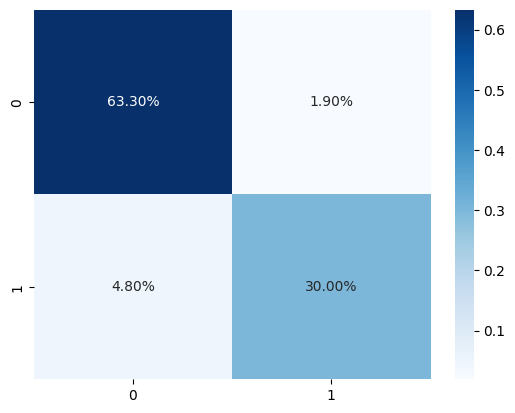

In [9]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')